# Data Science
- Student: Dmytro Geleshko
- Group: IP-91
- Var: 6

# Imports

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

# Config

In [17]:
# var 6
np.random.seed(6)
plt.rcParams["figure.figsize"] = (20, 8)
pd.set_option("display.max_columns", None)
pd.options.display.float_format = "{:,.3f}".format

# Load data

In [18]:
df = pd.read_csv("original_data.txt", sep="\t", index_col="date", parse_dates=True, dtype=str)
df.drop(columns=["change", "open", "high", "low"], inplace=True)
df

,close,volume
date,,
2021-11-25,58156.6,57.89K
2021-11-24,57171.7,56.68K
2021-11-23,57573.2,72.48K
2021-11-22,56308.8,76.45K
2021-11-21,58714.3,40.98K
...,...,...
2010-07-22,0.1,2.16K
2010-07-21,0.1,0.58K
2010-07-20,0.1,0.26K


# Transform

In [19]:
df.index.dtype, df.dtypes

(dtype('<M8[ns]'),
 close     object
 volume    object
 dtype: object)

In [20]:
# cast close
df["close"] = df["close"].astype(np.float32)

# cast volume
_vol = np.ones((df.shape[0]), dtype=float)
for i, vol in enumerate(df["volume"]):
    coef = 1
    if vol == "-":
        vol = "0"
    elif "K" in vol:
        coef = 1000
        vol = vol.replace("K", "")
    elif "M" in vol:
        coef = 1000000
        vol = vol.replace("M", "")
    _vol[i] = float(vol) * coef

df["volume"] = _vol.astype(np.float32)
df

,close,volume
date,,
2021-11-25,"58,156.602","57,890.000"
2021-11-24,"57,171.699","56,680.000"
2021-11-23,"57,573.199","72,480.000"
2021-11-22,"56,308.801","76,450.000"
2021-11-21,"58,714.301","40,980.000"
...,...,...
2010-07-22,0.100,"2,160.000"
2010-07-21,0.100,580.000
2010-07-20,0.100,260.000


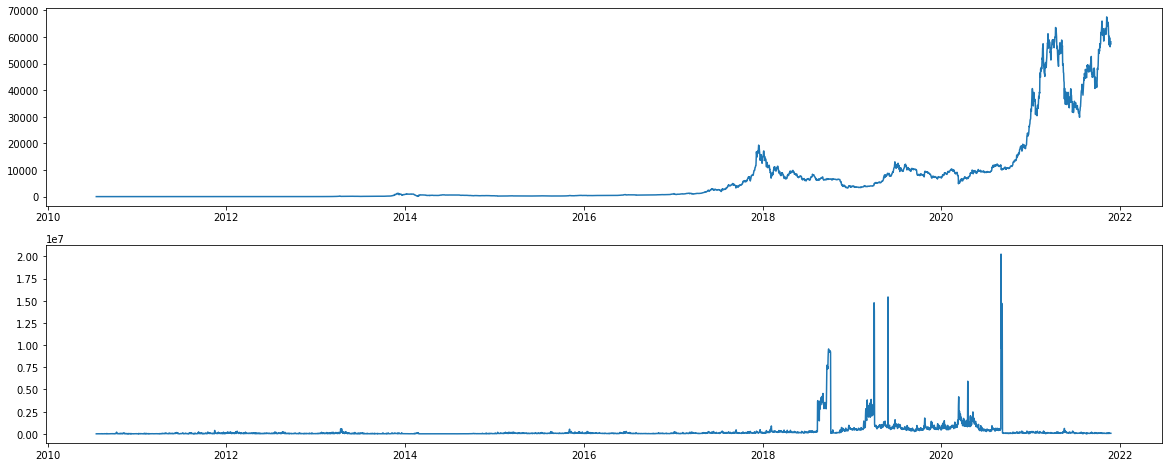

In [21]:
fig, axes = plt.subplots(2, 1)
axes[0].plot(df.index, df["close"])
axes[1].plot(df.index, df["volume"])
plt.show()

In [22]:
df.sort_index(inplace=True)

# Further work

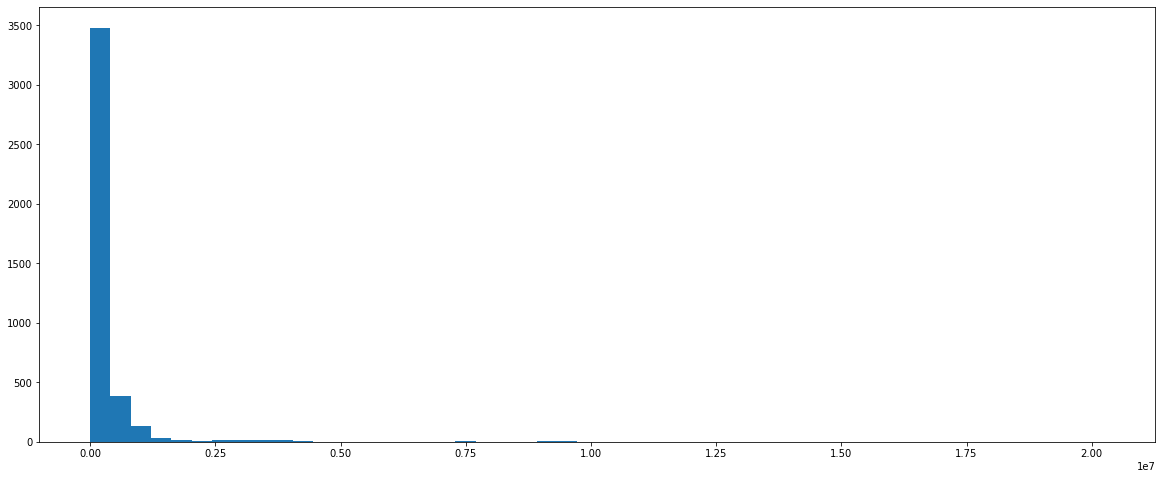

In [23]:
plt.hist(df["volume"], bins=50)
plt.show()

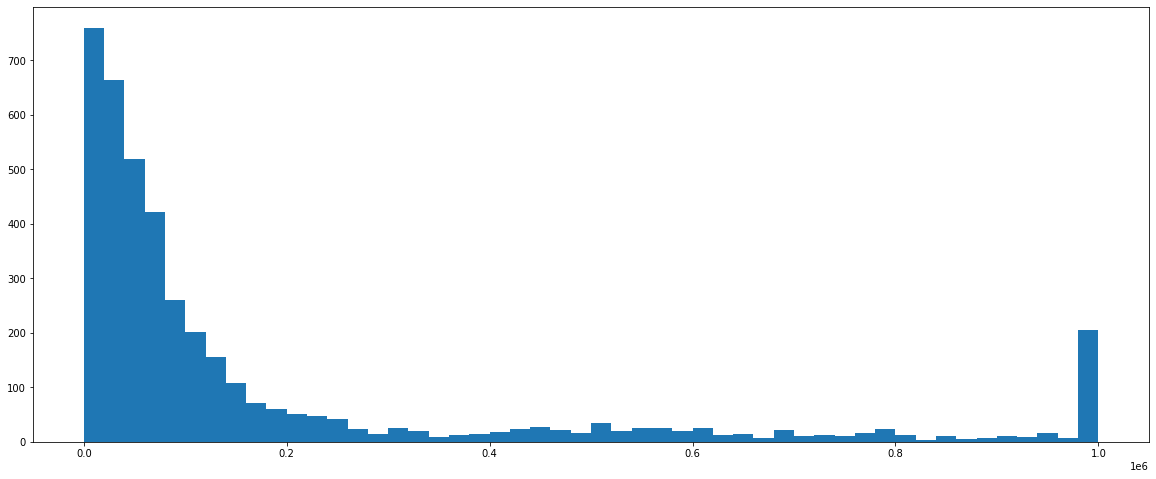

In [24]:
# clip volume and normalize
df["volume"] = np.clip(df["volume"], 0, 1000000)

plt.hist(df["volume"], bins=50)
plt.show()

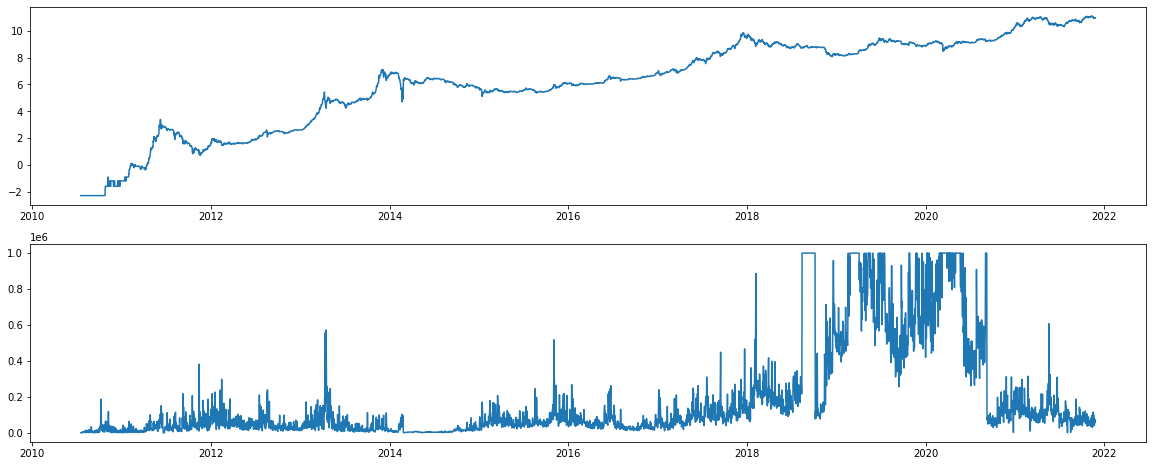

In [25]:
# normalize
vol_mean = df["volume"].mean()
vol_std = df["volume"].std()

np.save("saved_params/volume_mean_std.npy", np.array([vol_mean, vol_std]))

df["volume_norm"] = (df["volume"] - vol_mean)/vol_std
df["log_close"] = np.log(df["close"].values)

fig, axes = plt.subplots(2, 1)
axes[0].plot(df.index, df["log_close"])
axes[1].plot(df.index, df["volume"])
plt.show()

# Time features

In [26]:
day = 24*60*60
year = (365.2425)*day
month = year/12

timestamp_s = df.index.map(pd.Timestamp.timestamp)

df["month_sin"] = np.sin(timestamp_s * (2 * np.pi / month))
df["month_cos"] = np.cos(timestamp_s * (2 * np.pi / month))
df["year_sin"] = np.sin(timestamp_s * (2 * np.pi / year))
df["year_cos"] = np.cos(timestamp_s * (2 * np.pi / year))
df

,close,volume,volume_norm,log_close,month_sin,month_cos,year_sin,year_cos
date,,,,,,,,
2010-07-18,0.100,80.000,-0.674,-2.303,-0.095,-0.995,-0.266,-0.964
2010-07-19,0.100,570.000,-0.672,-2.303,-0.297,-0.955,-0.283,-0.959
2010-07-20,0.100,260.000,-0.673,-2.303,-0.486,-0.874,-0.299,-0.954
2010-07-21,0.100,580.000,-0.672,-2.303,-0.655,-0.756,-0.316,-0.949
2010-07-22,0.100,"2,160.000",-0.666,-2.303,-0.796,-0.605,-0.332,-0.943
...,...,...,...,...,...,...,...,...
2021-11-21,"58,714.301","40,980.000",-0.523,10.980,-0.863,-0.505,-0.643,0.766
2021-11-22,"56,308.801","76,450.000",-0.392,10.939,-0.948,-0.317,-0.630,0.777
2021-11-23,"57,573.199","72,480.000",-0.406,10.961,-0.993,-0.116,-0.616,0.787


# To float32

In [27]:
df.dtypes

close          float32
volume         float64
volume_norm    float64
log_close      float32
month_sin      float64
month_cos      float64
year_sin       float64
year_cos       float64
dtype: object

In [28]:
df = df.astype({
    "volume":np.float32,
    "volume_norm":np.float32, 
    "month_sin":np.float32,
    "month_cos":np.float32, 
    "year_sin":np.float32, 
    "year_cos":np.float32})

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4149 entries, 2010-07-18 to 2021-11-25
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   close        4149 non-null   float32
 1   volume       4149 non-null   float32
 2   volume_norm  4149 non-null   float32
 3   log_close    4149 non-null   float32
 4   month_sin    4149 non-null   float32
 5   month_cos    4149 non-null   float32
 6   year_sin     4149 non-null   float32
 7   year_cos     4149 non-null   float32
dtypes: float32(8)
memory usage: 162.1 KB


# Save

In [29]:
df.to_csv("mod_data.csv")